##Data Collection


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from tensorflow.keras.preprocessing.sequence import pad_sequences



import re
import string
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


color = sns.color_palette()
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


##Exploratory Analysis

###Load data set

In [ ]:
# Load Tweet dataset# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [ ]:
#df= df.loc[df['Drug'].isin(['cymbalta','lisinopril solution', 'lisinopril','lexapro','hydrocodone-acetaminophen','effexor xr','lyrica','tramadol hcl er', 'tramadol hcl', 'zoloft'])]

In [ ]:
df.shape

(362806, 13)

In [ ]:
# create a new dataframe with only the reviews column and sentiment column
df = df.loc[:, ['Reviews', 'sentiment']]

In [ ]:
df.head()

,Reviews,sentiment
0,I'm a retired physician and of all the meds I ...,Positive
1,cleared me right up even with my throat hurtin...,Positive
2,why did my PTINR go from a normal of 2.5 to ov...,Neutral
3,FALLING AND DON'T REALISE IT,Negative
4,My grandfather was prescribed this medication ...,Negative


In [ ]:
# Drop all rows with a rating of 3
df = df.loc[df['sentiment'] != 'Neutral']


###Determine size of data set

In [ ]:
df = df.loc[:80000,:]

In [ ]:
df.shape

(67937, 2)

In [ ]:
df['Reviews'].apply(lambda x:len(str(x).split())).max()

424

###Train Test Split

In [ ]:
# Split the data into training and testing sets (70% for training and 30% for testing)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Split the training data into training and validation sets (50% for training and 50% for validation)
#df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)


###Removing Duplicates and Emply rows

In [ ]:
#print the number of null values in each column
df_test.isnull().sum()

Reviews      3
sentiment    0
dtype: int64

In [ ]:
df_train = df_train.dropna()
df_test = df_train.dropna()

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Reviews'].duplicated() == True]

,Reviews,sentiment
53,,Negative
5041,back pain,Negative
6119,ok,Positive
6802,good,Negative
7912,weight gain,Negative
7933,makes me sleepy,Positive
10422,none,Positive
12801,it helps,Positive
22452,insomnia,Positive
23979,headaches,Positive


In [ ]:
#print some of those rows to check
df_train[df_train['Reviews'] == df_train.iloc[3548]['Reviews']]

,Reviews,sentiment
3548,After taking this drug for more than 10 yrs. I...,Negative


In [ ]:
#removing duplicated text
index = df_train[df_train['Reviews'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
df_train.shape

(31807, 2)

###Removing Stopwords and converting to lower cases

In [ ]:
import string
from nltk.corpus import stopwords

In [ ]:
def data_cleaning(raw_data):

    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))

    words = raw_data.lower().split()

    stops = set(stopwords.words("english"))

    useful_words = [w for w in words if not w in stops]

    return( " ".join(useful_words))


In [ ]:
df_train['Reviews']= df_train['Reviews'].apply(data_cleaning)

In [ ]:
df_test["Reviews"]=df_test["Reviews"].apply(data_cleaning)

In [ ]:
df_train['Reviews']

0        month seen change perhaps need little longer m...
1             take pain med diabetic perpheral neourapathy
2        lost thyroidhair lossdry mouthconstant ringing...
3        ortho tricyclen worked well however switch gen...
4        taking gabapentin couple year helped periphera...
                               ...                        
31802    sore stiff take mg neurontin every nite really...
31803    stopped taking mg norpramine fall depression b...
31804                                             far good
31805    took fibromyalgia pain within hours gums start...
31806    ever since first episode anxiety blood pressur...
Name: Reviews, Length: 31807, dtype: object

###Visualizing the words majorly found through Wordclouds

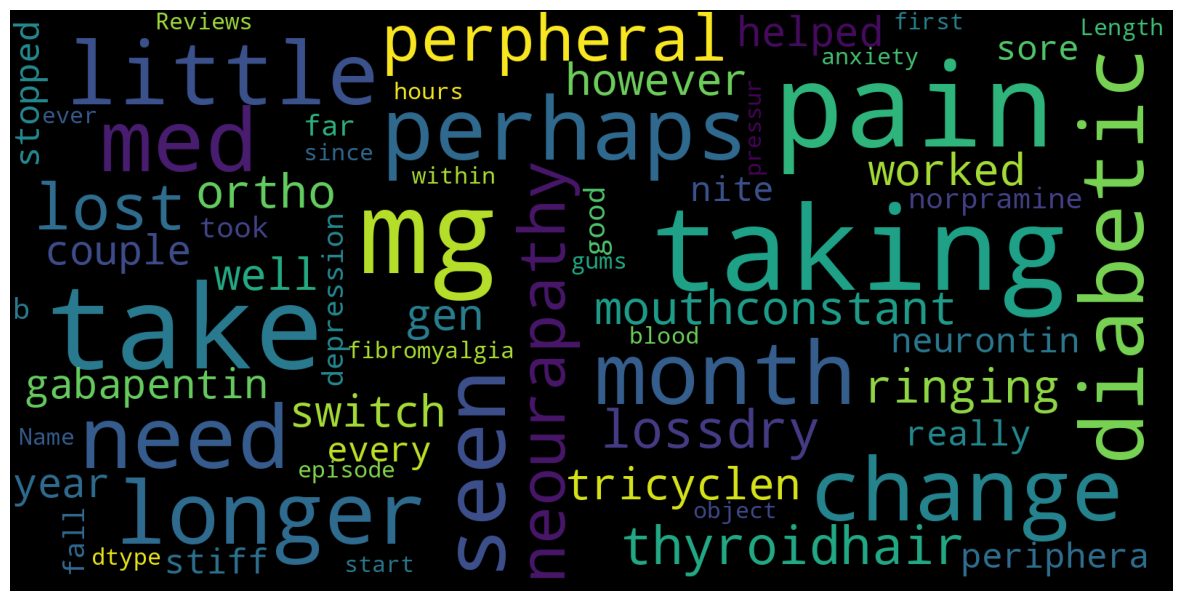

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

def generate_wordcloud(data, title=None):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(
        stopwords=stopwords_set,
        max_words=100,
        max_font_size=40,
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train['Reviews'])


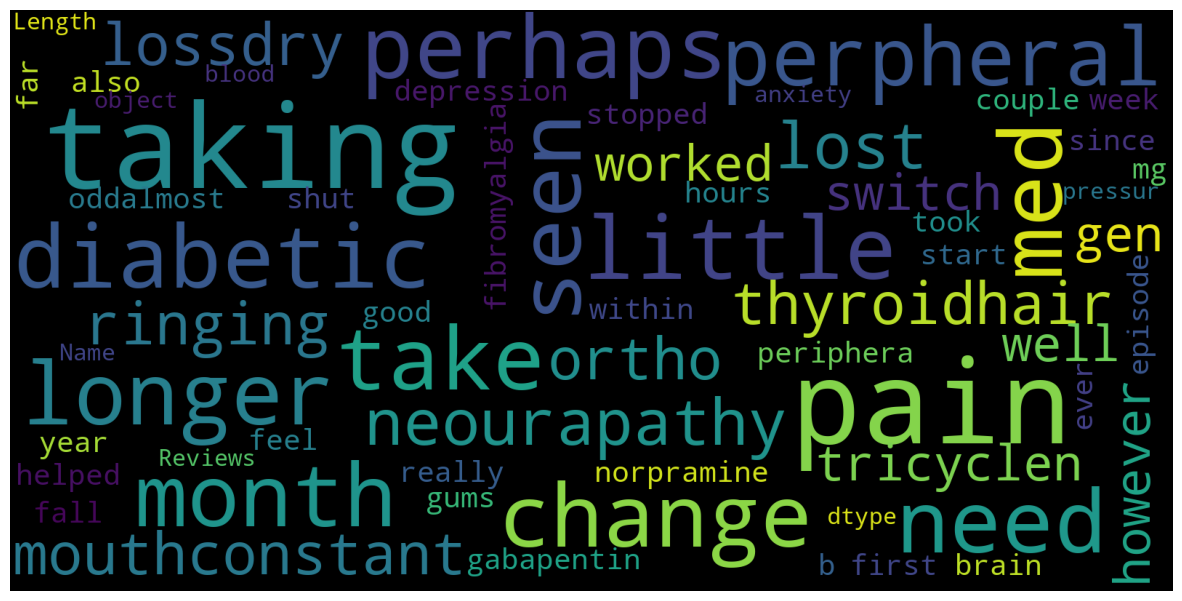

In [ ]:
generate_wordcloud(df_test["Reviews"])

###Visualizing class distribution

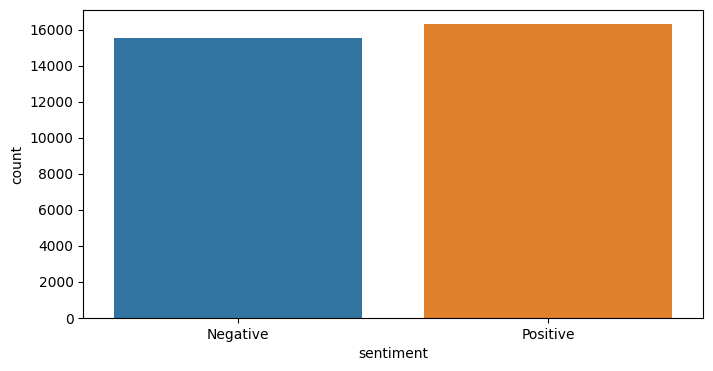

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train);

###Extra; Auc score function

In [ ]:
#a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

###Encoding and Transforming

In [ ]:
xtrain = df_train['Reviews']
ytrain = df_train['sentiment']

In [ ]:
xtest = df_test['Reviews']
ytest = df_test['sentiment']

In [ ]:
print(ytrain)

0        Negative
1        Positive
2        Negative
3        Positive
4        Positive
           ...   
31802    Positive
31803    Negative
31804    Positive
31805    Negative
31806    Negative
Name: sentiment, Length: 31807, dtype: object


In [ ]:
le = LabelEncoder()
ytrain = df_train.sentiment.values
ytrain = le.fit_transform(ytrain)

In [ ]:
print(ytrain)

[0 1 0 ... 1 0 0]


In [ ]:
print(ytest)

32881    Negative
49909    Positive
8911     Negative
70527    Positive
66333    Positive
           ...   
43731    Negative
7342     Positive
64667    Negative
1009     Negative
18770    Negative
Name: sentiment, Length: 47549, dtype: object


In [ ]:
ytest = df_test.sentiment.values
ytest= le.fit_transform(ytest)

In [ ]:
print(ytest)

[0 1 0 ... 0 0 0]


In [ ]:
xtrain.shape, ytrain.shape

((31807,), (31807,))

###Tokenizing

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=10000)
max_len = 600

token.fit_on_texts(list(xtrain))
xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)


#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
print(len(word_index))

42497


###Creating Embedding Matrix

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:56, 12456.86it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 42497/42497 [00:00<00:00, 392154.80it/s]


##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
import numpy as np



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###RNN

In [ ]:
def create_rnn_model(units=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(SimpleRNN(units=units))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Defining the hyperparameters to search
pbounds = {'units': (32, 500), 'dropout_rate': (0.2, 0.9)}

# Creating the RNN model using KerasClassifier
model = KerasClassifier(build_fn=create_rnn_model, epochs=10, batch_size=32)

# Define the function to optimize
def optimize_rnn(units, dropout_rate):
    model.set_params(units=int(units), dropout_rate=float(dropout_rate))

    return np.mean(cross_val_score(model,xtrain_pad, ytrain, cv=3, n_jobs=-1, scoring='accuracy'))


# Apply Bayesian optimization
optimizer = BayesianOptimization(f=optimize_rnn, pbounds=pbounds, random_state=42)
optimizer.maximize(n_iter=10)

best_params = optimizer.max['params']

|   iter    |  target   | dropou... |   units   |
-------------------------------------------------
| 1         | 0.5824    | 0.4622    | 476.9     |
| 2         | 0.5843    | 0.7124    | 312.2     |
| 3         | 0.6461    | 0.3092    | 105.0     |
| 4         | 0.6002    | 0.2407    | 437.4     |
| 5         | 0.5711    | 0.6208    | 363.4     |
| 6         | 0.6614    | 0.4253    | 104.1     |
| 7         | 0.6761    | 0.2702    | 101.5     |
| 8         | 0.6595    | 0.8588    | 95.96     |
| 9         | 0.7077    | 0.2789    | 88.62     |
| 10        | 0.5828    | 0.9       | 83.7      |


KeyboardInterrupt: ignored

###LSTM

In [ ]:
def create_lstm_model(units=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(units=units, dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters to search
pbounds = {'units': (32, 500), 'dropout_rate': (0.2, 0.9)}

# Create the LSTM model using KerasClassifier
model = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=64)

# Define the function to optimize
def optimize_lstm(units, dropout_rate):
    model.set_params(units=int(units), dropout_rate=float(dropout_rate))
    return np.mean(cross_val_score(model,xtrain_pad, ytrain, cv=3, n_jobs=-1, scoring='accuracy'))


# Apply Bayesian optimization
optimizer = BayesianOptimization(f=optimize_lstm, pbounds=pbounds, random_state=42)
optimizer.maximize(n_iter=10)

best_params = optimizer.max['params']

|   iter    |  target   | dropou... |   units   |
-------------------------------------------------
| 1         | 0.784     | 0.4622    | 476.9     |
| 2         | 0.7682    | 0.7124    | 312.2     |
| 3         | 0.8003    | 0.3092    | 105.0     |
| 4         | 0.7879    | 0.2407    | 437.4     |
| 5         | 0.7893    | 0.6208    | 363.4     |
| 6         | 0.7998    | 0.4813    | 103.9     |
| 7         | 0.7385    | 0.8961    | 142.2     |
| 8         | 0.7985    | 0.5856    | 394.2     |
| 9         | 0.749     | 0.9       | 413.3     |
| 10        | 0.795     | 0.2948    | 381.4     |
| 11        | 0.7957    | 0.2       | 80.01     |
| 12        | 0.8007    | 0.2455    | 60.62     |
| 13        | 0.7651    | 0.8021    | 42.19     |


KeyboardInterrupt: ignored

###Bi-directional LSTM

In [ ]:
def create_bilstm_model(units=300, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

    model.add(Bidirectional(LSTM(units=units, dropout=dropout_rate)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters to search
pbounds = {'units': (32, 500), 'dropout_rate': (0.2, 0.9)}

# Create the Bidirectional LSTM model using KerasClassifier
model = KerasClassifier(build_fn= create_bilstm_model, epochs=10, batch_size=64)

# Define the function to optimize
def optimize_bilstm(units, dropout_rate):
    model.set_params(units=int(units), dropout_rate=float(dropout_rate))
    return np.mean(cross_val_score(model,xtrain_pad, ytrain, cv=3, n_jobs=-1, scoring='accuracy'))


# Apply Bayesian optimization
optimizer = BayesianOptimization(f=optimize_bilstm, pbounds=pbounds, random_state=42)
optimizer.maximize(n_iter=10)

|   iter    |  target   | dropou... |   units   |
-------------------------------------------------
| 1         | 0.7743    | 0.4622    | 476.9     |
| 2         | 0.7981    | 0.7124    | 312.2     |
| 3         | 0.7995    | 0.3092    | 105.0     |
| 4         | 0.6954    | 0.2407    | 437.4     |
| 5         | 0.7218    | 0.6208    | 363.4     |
| 6         | 0.7468    | 0.8848    | 106.2     |
| 7         | 0.7969    | 0.2505    | 105.1     |
| 8         | 0.7998    | 0.2678    | 103.5     |
| 9         | 0.772     | 0.5626    | 310.0     |
| 10        | 0.7593    | 0.8818    | 314.3     |


KeyboardInterrupt: ignored

In [ ]:
# Obtain the best hyperparameters
best_params = optimizer.max['params']
print(best_params)

###GRU

In [ ]:
def create_gru_model(units=300, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters to search
pbounds = {'units': (32, 500), 'dropout_rate': (0.2, 0.9)}

# Create the GRU model using KerasClassifier
model = KerasClassifier(build_fn=create_gru_model, epochs=10, batch_size=64)

# Define the function to optimize
def optimize_gru(units, dropout_rate):
    model.set_params(units=int(units), dropout_rate=float(dropout_rate))
    return np.mean(cross_val_score(model,xtrain_pad, ytrain, cv=3, n_jobs=-1, scoring='accuracy'))


# Apply Bayesian optimization
optimizer = BayesianOptimization(f=optimize_gru, pbounds=pbounds, random_state=42)
optimizer.maximize(n_iter=10)

|   iter    |  target   | dropou... |   units   |
-------------------------------------------------
| 1         | 0.7973    | 0.4622    | 476.9     |
| 2         | 0.7998    | 0.7124    | 312.2     |
| 3         | 0.8014    | 0.3092    | 105.0     |
| 4         | 0.793     | 0.2407    | 437.4     |
| 5         | 0.801     | 0.6208    | 363.4     |
| 6         | 0.7922    | 0.6858    | 139.5     |
| 7         | 0.7612    | 0.8296    | 106.1     |
| 8         | 0.804     | 0.6397    | 363.4     |
| 9         | 0.755     | 0.8771    | 363.7     |
| 10        | 0.7935    | 0.4557    | 363.5     |
| 11        | 0.8011    | 0.2682    | 105.2     |
| 12        | 0.7998    | 0.5093    | 417.8     |


KeyboardInterrupt: ignored

In [ ]:
# Obtain the best hyperparameters
best_params = optimizer.max['params']
print(best_params)